In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src.utility.logger import append_log
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from typing import Tuple, List, Dict
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [41]:
in_dir = Path("data/processed/01")
folds = {}
for i in range(1, 3):
    print(f"Reading fold {i}:")
    folds[f"fold_{i}"] = {
        "X_train": pd.read_csv(f'{in_dir}/fold_{i}_X_train.csv'),
        "X_test": pd.read_csv(f'{in_dir}/fold_{i}_X_test.csv'),
        "y_train": pd.read_csv(f'{in_dir}/fold_{i}_y_train.csv').squeeze(),
        "y_test": pd.read_csv(f'{in_dir}/fold_{i}_y_test.csv').squeeze()
    }

X_train = folds["fold_1"]["X_train"];
y_train = folds["fold_1"]["y_train"];

print("Ready for Feature Classification:")
print(f"  Training features: {X_train.shape}")
print(f"  Features to classify: {len(X_train.columns)}")
print(f"  Data integrity verified: ✅")

Reading fold 1:
Reading fold 2:
Ready for Feature Classification:
  Training features: (16406, 16)
  Features to classify: 16
  Data integrity verified: ✅


/var/folders/b2/s4rlr80x3t7gkl68_gp_8ftc0000gn/T/ipykernel_89826/2797354351.py:6: DtypeWarning: Columns (2,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  "X_train": pd.read_csv(f'{in_dir}/fold_{i}_X_train.csv'),


In [42]:
print("Training features:")
X_train.info()

Training features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16406 entries, 0 to 16405
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_id    8495 non-null   float64
 1   sensors_id     8495 non-null   float64
 2   location       8495 non-null   object 
 3   datetime       16406 non-null  object 
 4   lat            8495 non-null   float64
 5   lon            8495 non-null   float64
 6   parameter      8495 non-null   object 
 7   units          8495 non-null   object 
 8   temp_C         16326 non-null  float64
 9   dewpoint_C     16309 non-null  float64
 10  slp_hPa        16224 non-null  float64
 11  wind_dir_deg   15970 non-null  float64
 12  wind_speed_ms  0 non-null      float64
 13  sky_cover      16326 non-null  object 
 14  precip_mm      13303 non-null  float64
 15  year           16406 non-null  int64  
dtypes: float64(10), int64(1), object(5)
memory usage: 2.0+ MB


In [43]:
print("Training target:")
y_train.info()

Training target:
<class 'pandas.core.series.Series'>
RangeIndex: 16406 entries, 0 to 16405
Series name: target
Non-Null Count  Dtype  
--------------  -----  
8495 non-null   float64
dtypes: float64(1)
memory usage: 128.3 KB


In [44]:
X_train.describe()

,location_id,sensors_id,lat,lon,temp_C,dewpoint_C,slp_hPa,wind_dir_deg,wind_speed_ms,precip_mm,year
count,8495.0,8495.0,8495.000000,8495.000000,16326.000000,16309.000000,16224.000000,15970.000000,0.0,13303.000000,16406.000000
mean,9369.0,28602.0,47.156766,27.574866,120.281943,60.794285,10177.894847,20.701565,NaN,5.939788,2020.465318
std,0.0,0.0,0.000000,0.000000,93.445686,78.230592,79.398219,10.585016,NaN,2.385252,0.498811
min,9369.0,28602.0,47.156766,27.574866,-160.000000,-181.000000,9913.000000,1.000000,NaN,0.000000,2020.000000
25%,9369.0,28602.0,47.156766,27.574866,42.000000,-1.000000,10125.000000,10.000000,NaN,4.000000,2020.000000
50%,9369.0,28602.0,47.156766,27.574866,119.000000,58.000000,10168.000000,25.000000,NaN,7.000000,2020.000000
75%,9369.0,28602.0,47.156766,27.574866,191.000000,127.000000,10231.000000,30.000000,NaN,8.000000,2021.000000
max,9369.0,28602.0,47.156766,27.574866,354.000000,236.000000,10445.000000,36.000000,NaN,9.000000,2021.000000


In [45]:
y_train.describe()

count    8495.000000
mean       41.282029
std        36.122104
min         0.972326
25%        25.516211
50%        36.555993
75%        50.641325
max      2217.676463
Name: target, dtype: float64

In [46]:
def plot_numeric_distribution(df, column, label=None, bins=30):
    """
    Plot histogram + boxplot for a numeric feature.
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the feature.
    column : str
        Column name to plot.
    label : str, optional
        Pretty label for titles/axes (defaults to column name).
    bins : int
        Number of bins for histogram.
    """
    if label is None:
        label = column

    # Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], bins=bins, kde=True)
    plt.title(f"Distribution of {label}")
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {label}")
    plt.xlabel(label)
    plt.show()

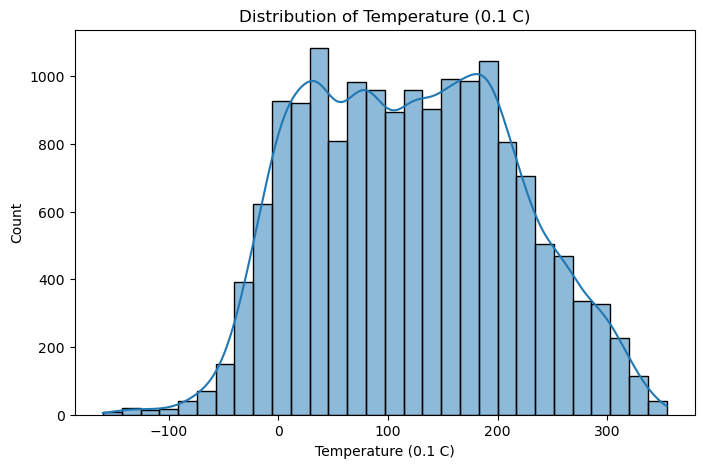

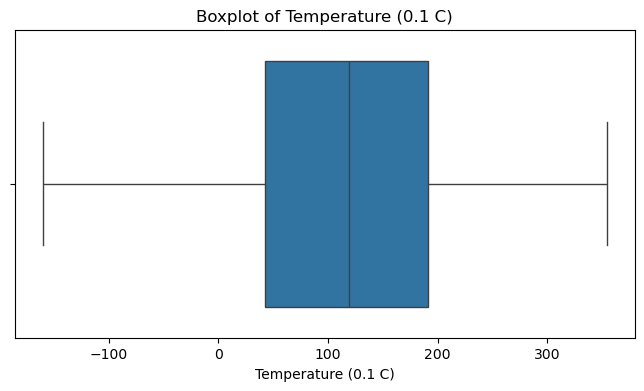

In [47]:
plot_numeric_distribution(X_train, "temp_C", label="Temperature (0.1 C)")

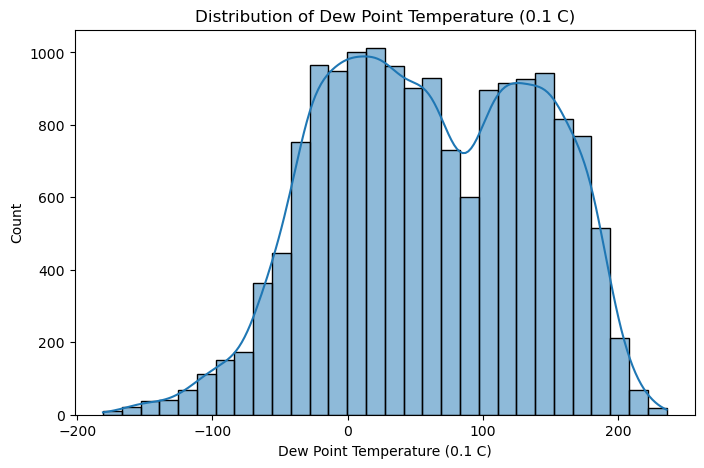

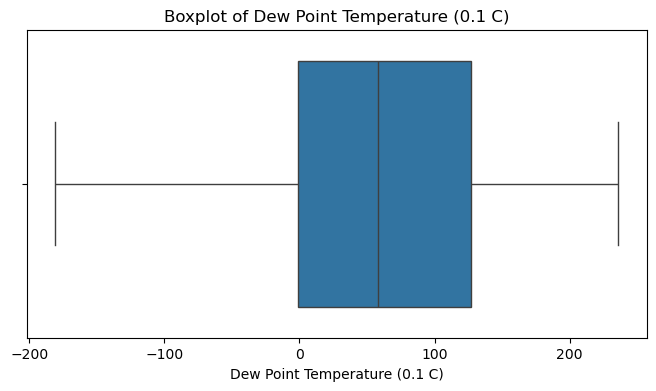

In [48]:
plot_numeric_distribution(X_train, "dewpoint_C", label="Dew Point Temperature (0.1 C)")

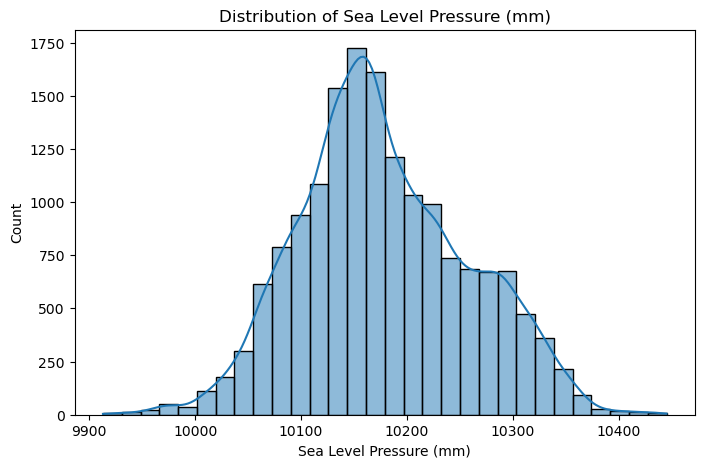

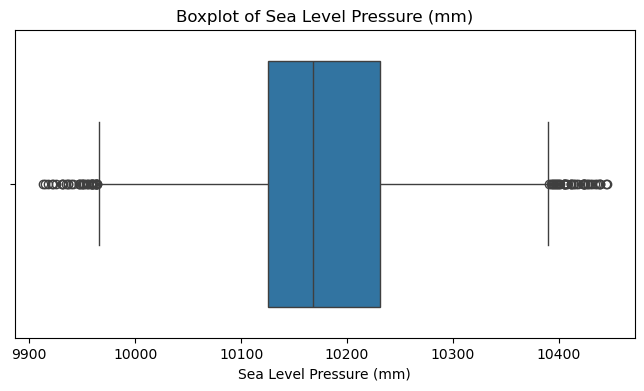

In [49]:
plot_numeric_distribution(X_train, "slp_hPa", label="Sea Level Pressure (mm)")

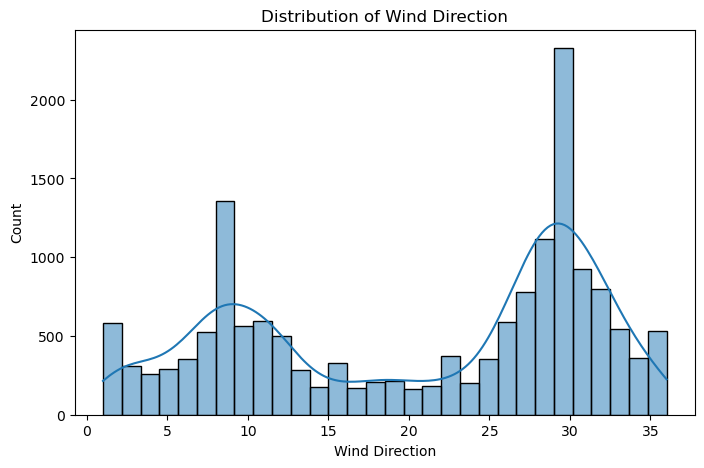

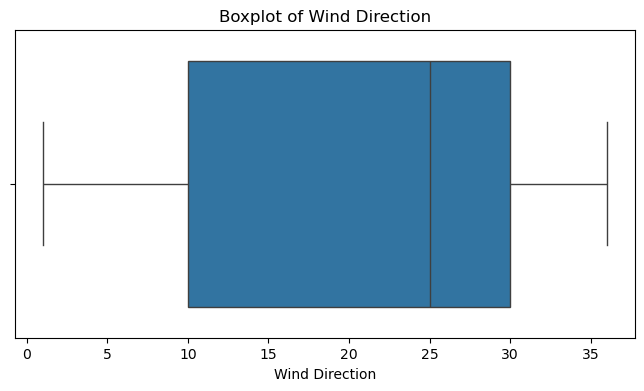

In [50]:
plot_numeric_distribution(X_train, "wind_dir_deg", label="Wind Direction")

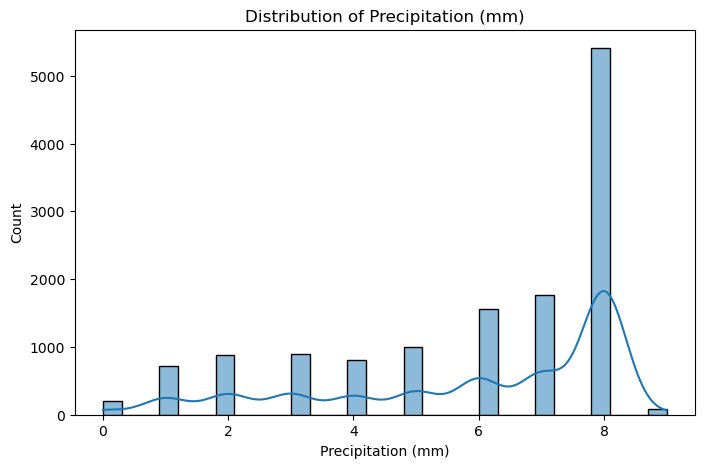

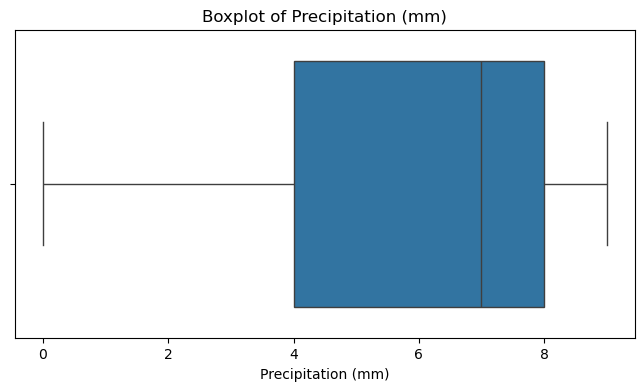

In [51]:
plot_numeric_distribution(X_train, "precip_mm", label="Precipitation (mm)")

In [52]:
def detect_outliers_iqr(df, column, factor=1.5, return_filtered=True):
    """
    Detect outliers in a numeric column using the IQR method.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the column.
    column : str
        Column name to check for outliers.
    factor : float, default=1.5
        Multiplier for IQR (1.5 = Tukey's rule, 3 = more conservative).
    return_filtered : bool, default=True
        Whether to also return the dataframe without outliers.

    Returns
    -------
    outlier_info : dict
        Dictionary with bounds, number of outliers, percentage.
    df_filtered : pd.DataFrame (if return_filtered=True)
        The dataframe with outliers removed.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    mask_outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    n_outliers = mask_outliers.sum()
    perc_outliers = n_outliers / len(df) * 100

    outlier_info = {
        "column": column,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "n_outliers": int(n_outliers),
        "perc_outliers": round(perc_outliers, 2),
        "n_total": len(df),
    }

    if return_filtered:
        df_filtered = df.loc[~mask_outliers].copy()
        return outlier_info, df_filtered
    else:
        return outlier_info

In [53]:
info, df_no_outliers = detect_outliers_iqr(X_train, "temp_C")
print(info)

info, df_no_outliers = detect_outliers_iqr(X_train, "dewpoint_C")
print(info)

info, df_no_outliers = detect_outliers_iqr(X_train, "slp_hPa")
print(info)

info, df_no_outliers = detect_outliers_iqr(X_train, "precip_mm")
print(info)

{'column': 'temp_C', 'lower_bound': np.float64(-181.5), 'upper_bound': np.float64(414.5), 'n_outliers': 0, 'perc_outliers': np.float64(0.0), 'n_total': 16406}
{'column': 'dewpoint_C', 'lower_bound': np.float64(-193.0), 'upper_bound': np.float64(319.0), 'n_outliers': 0, 'perc_outliers': np.float64(0.0), 'n_total': 16406}
{'column': 'slp_hPa', 'lower_bound': np.float64(9966.0), 'upper_bound': np.float64(10390.0), 'n_outliers': 79, 'perc_outliers': np.float64(0.48), 'n_total': 16406}
{'column': 'precip_mm', 'lower_bound': np.float64(-2.0), 'upper_bound': np.float64(14.0), 'n_outliers': 0, 'perc_outliers': np.float64(0.0), 'n_total': 16406}


In [54]:
summary = pd.DataFrame({
    'Feature Name': X_train.columns,
    'Type': X_train.dtypes,
    'Missing?': X_train.isnull().mean().round(2),
    'Unique Values': X_train.nunique()
})
summary

,Feature Name,Type,Missing?,Unique Values
location_id,location_id,float64,0.48,1
sensors_id,sensors_id,float64,0.48,1
location,location,object,0.48,1
datetime,datetime,object,0.00,16406
lat,lat,float64,0.48,1
lon,lon,float64,0.48,1
parameter,parameter,object,0.48,1
units,units,object,0.48,1
temp_C,temp_C,float64,0.00,482
dewpoint_C,dewpoint_C,float64,0.01,400


Missing target values (`NaN`) were removed from the training and test datasets to ensure the integrity of the regression modeling process. Since the target variable is required for supervised learning, rows with undefined values cannot contribute to model training or evaluation. Imputing the target values would introduce synthetic or biased information, potentially distorting the learning process and model performance. Therefore, removing these rows is the most transparent and statistically sound approach, ensuring that the model is trained and validated only on reliable, observed outcomes.

In [55]:
def drop_y_na(X, y):
    """Drop rows where y is NaN, keep X/y aligned."""
    mask = y.notna()
    return X.loc[mask].copy(), y.loc[mask].copy()

for fold_name, d in folds.items():
    d["X_train"], d["y_train"] = drop_y_na(d["X_train"], d["y_train"])
    d["X_test"],  d["y_test"]  = drop_y_na(d["X_test"],  d["y_test"])

In [56]:
append_log(
    "outputs/logs/data_cleaning_log.txt",
    [
        f"Removed rows from train/test datasets where target is NaN",
    ]
)

In [57]:
class SimpleTypeCoercer(BaseEstimator, TransformerMixin):

    def __init__(self, conversion_dict):
        self.conversion_dict = conversion_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xc = X.copy()
        for col, dtype in self.conversion_dict.items():
            if col in Xc.columns:
                try:
                    Xc[col] = Xc[col].astype(dtype, errors="ignore")
                except Exception as e:
                    print(f"[TypeCoercer] Could not convert {col} to {dtype}: {e}")
        return Xc

In [58]:
def make_dt_block(datetime_col="datetime", tz="Europe/Bucharest"):
    def _to_df(X):
        # ColumnTransformer may pass a DataFrame or a 2D numpy array
        if isinstance(X, pd.DataFrame):
            return X
        # assume single column array, rebuild as DataFrame
        return pd.DataFrame({datetime_col: np.asarray(X).ravel()})

    def _extract(X):
        X = _to_df(X)

        # 1) parse to datetime; strings like "...+02:00" become tz-aware
        s = pd.to_datetime(X[datetime_col], errors="coerce")

        # 2) ensure timezone: convert if tz-aware, localize if naive
        try:
            s = s.dt.tz_convert(tz)              # works when s is already tz-aware
        except TypeError:
            # not tz-aware yet → localize; handle DST safely
            s = s.dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")

        # 3) now dt accessors are safe
        out = pd.DataFrame({
            "dt__hour": s.dt.hour,
            "dt__dow": s.dt.dayofweek,
            "dt__month": s.dt.month,
            "dt__is_weekend": (s.dt.dayofweek >= 5).astype(int),
        }, index=X.index)
        return out

    def _feature_names(_, input_features=None):
        return np.array(["dt__hour", "dt__dow", "dt__month", "dt__is_weekend"])

    return FunctionTransformer(_extract, feature_names_out=_feature_names)

In [59]:
# ---- helper selectors that EXCLUDE certain columns ----
def make_num_selector(exclude: list[str]):
    def _sel(X):
        cols = X.select_dtypes(include=np.number).columns.tolist()
        return [c for c in cols if c not in exclude]
    return _sel

def make_cat_selector(exclude: list[str]):
    def _sel(X):
        cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
        return [c for c in cols if c not in exclude]
    return _sel

In [60]:
def build_pipeline() -> Pipeline:
    """Preprocess (num+cat+optional datetime) then drop zero-variance columns."""
    # columns to exclude from OHE / numeric preprocessing
    exclude_from_ohe_and_num = ["datetime", "year"]

    conversion_dict = {
    'location_id': 'int64',
    'sensors_id': 'int64',
    'location': 'category',
    'lat': 'float64',
    'lon': 'float64',
    'parameter': 'category',
    'units': 'category',
    'value': 'float64',
    'temp_C': 'float64',
    'dewpoint_C': 'float64',
    'slp_hPa': 'float64',
    'wind_dir_deg': 'float64',
    'wind_speed_ms': 'float64',
    'sky_cover': 'category',
    'precip_mm': 'float64'
    }
    coerce = SimpleTypeCoercer(conversion_dict)

    # Numeric: impute + scale
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    # Categorical: impute + one-hot
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    
    dt_pipe = Pipeline([
        ("dt_extract", make_dt_block("datetime")),
        ("scaler", StandardScaler()),
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipe, make_num_selector(exclude_from_ohe_and_num)),
        ("cat", cat_pipe, make_cat_selector(exclude_from_ohe_and_num)),
        ("dt",  dt_pipe, ["datetime"]),
    ])

    pipeline = Pipeline(steps=[
        ("coerce_types", coerce),
        ("preprocessor", preprocessor),
        ("zero_var", VarianceThreshold(threshold=0.0))
    ])
    return pipeline

In [61]:
def apply_pipeline(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    fold_name: str = "fold_1",
    log_path: str = "outputs/logs/preprocess_log.txt",
) -> Tuple[pd.DataFrame, pd.DataFrame, Pipeline, List[str]]:
    """
    Fit the pipeline on X_train (preprocess + drop zero-variance), transform X_test,
    and return DataFrames with correct post-preprocessing feature names.
    """
    pipe = build_pipeline()

    # Fit on train, transform both
    X_train_arr = pipe.fit_transform(X_train)
    X_test_arr  = pipe.transform(X_test)

    # Names AFTER preprocessing (num+cat+dt)
    feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()

    # Support mask from VarianceThreshold (applies to preprocessed features)
    support = pipe.named_steps["zero_var"].get_support()
    selected_cols = feature_names[support]
    dropped_cols = [c for c in feature_names if c not in set(selected_cols)]

    # Wrap arrays back to DataFrames with the selected feature names
    X_train_out = pd.DataFrame(X_train_arr, columns=selected_cols, index=X_train.index)
    X_test_out  = pd.DataFrame(X_test_arr,  columns=selected_cols, index=X_test.index)

    lines = [
        f"[{fold_name}] Zero-variance threshold: {0}",
        f"[{fold_name}] Kept features: {len(selected_cols)} / {len(feature_names)}",
        f"[{fold_name}] Dropped zero-variance features: {dropped_cols if dropped_cols else 'None'}"
    ]
    append_log(log_path, lines)
    print("\n".join(lines))

    return X_train_out, X_test_out, pipe

In [62]:
for fold_name, d in folds.items():
    Xtr, Xte = d["X_train"], d["X_test"]
    Xtr["datetime"] = pd.to_datetime(Xtr["datetime"], errors="coerce", utc=True)
    Xte["datetime"]  = pd.to_datetime(Xte["datetime"],  errors="coerce", utc=True)

    Xtr_zv, Xte_zv, pipe = apply_pipeline(
        Xtr, Xte, fold_name=fold_name,
        log_path="outputs/logs/preprocess_log.txt"
    )

    d["X_train"] = Xtr_zv
    d["X_test"]  = Xte_zv
    d["pipeline"] = pipe

[fold_1] Zero-variance threshold: 0
[fold_1] Kept features: 18 / 25
[fold_1] Dropped zero-variance features: ['num__location_id', 'num__sensors_id', 'num__lat', 'num__lon', 'cat__location_RO0083A-9369', 'cat__parameter_no2', 'cat__units_µg/m³']
[fold_2] Zero-variance threshold: 0
[fold_2] Kept features: 20 / 27
[fold_2] Dropped zero-variance features: ['num__location_id', 'num__sensors_id', 'num__lat', 'num__lon', 'cat__location_RO0083A-9369', 'cat__parameter_no2', 'cat__units_µg/m³']


/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['wind_speed_ms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['wind_speed_ms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['wind_speed_ms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/impute/_b

In [63]:
out_dir = Path("data/processed/02")
out_dir.mkdir(parents=True, exist_ok=True)

for fold_name, data in folds.items():
    pipeline = data.get("preprocessors") or data.get("pipeline")

    # Wrap arrays with headers if available
    X_train_df = pd.DataFrame(data["X_train"])
    X_test_df  = pd.DataFrame(data["X_test"])

    # Targets as Series with header
    y_train_s  = pd.Series(data["y_train"]).reset_index(drop=True)
    y_test_s   = pd.Series(data["y_test"]).reset_index(drop=True)
    y_train_s.name = "target"
    y_test_s.name  = "target"

    # Save
    X_train_df.to_csv(out_dir / f"{fold_name}_X_train.csv", index=False)
    X_test_df.to_csv(out_dir / f"{fold_name}_X_test.csv", index=False)
    y_train_s.to_csv(out_dir / f"{fold_name}_y_train.csv", index=False, header=True)
    y_test_s.to_csv(out_dir / f"{fold_name}_y_test.csv", index=False, header=True)

    print(f"Saved {fold_name} with headers to {out_dir}")

Saved fold_1 with headers to data/processed/02
Saved fold_2 with headers to data/processed/02


In [64]:
X_train = folds["fold_1"]["X_train"];
y_train = folds["fold_1"]["y_train"];
print("Training features:")
X_train.info()

Training features:
<class 'pandas.core.frame.DataFrame'>
Index: 8495 entries, 5075 to 16405
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num__temp_C         8495 non-null   float64
 1   num__dewpoint_C     8495 non-null   float64
 2   num__slp_hPa        8495 non-null   float64
 3   num__wind_dir_deg   8495 non-null   float64
 4   num__precip_mm      8495 non-null   float64
 5   cat__sky_cover_0    8495 non-null   float64
 6   cat__sky_cover_0 -  8495 non-null   float64
 7   cat__sky_cover_1    8495 non-null   float64
 8   cat__sky_cover_1 -  8495 non-null   float64
 9   cat__sky_cover_5    8495 non-null   float64
 10  cat__sky_cover_5 -  8495 non-null   float64
 11  cat__sky_cover_6    8495 non-null   float64
 12  cat__sky_cover_6 -  8495 non-null   float64
 13  cat__sky_cover_7 -  8495 non-null   float64
 14  dt__dt__hour        8495 non-null   float64
 15  dt__dt__dow         8495 non-null   f

In [65]:
print("Training target:")
y_train.info()

Training target:
<class 'pandas.core.series.Series'>
Index: 8495 entries, 5075 to 16405
Series name: target
Non-Null Count  Dtype  
--------------  -----  
8495 non-null   float64
dtypes: float64(1)
memory usage: 132.7 KB


In [66]:
X_train.describe()

,num__temp_C,num__dewpoint_C,num__slp_hPa,num__wind_dir_deg,num__precip_mm,cat__sky_cover_0,cat__sky_cover_0 -,cat__sky_cover_1,cat__sky_cover_1 -,cat__sky_cover_5,cat__sky_cover_5 -,cat__sky_cover_6,cat__sky_cover_6 -,cat__sky_cover_7 -,dt__dt__hour,dt__dt__dow,dt__dt__month,dt__dt__is_weekend
count,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8495.000000,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03
mean,8.029677e-17,4.182123e-17,2.977672e-15,-7.360537e-17,-9.995275e-17,0.780224,0.172808,0.007416,0.005297,0.018599,0.006710,0.005180,0.003649,0.000118,-8.280604e-17,-5.938615e-17,-1.070624e-16,-6.942325e-17
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,0.414119,0.378103,0.085802,0.072593,0.135113,0.081643,0.071786,0.060302,0.010850,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00
min,-3.002637e+00,-3.394120e+00,-2.868419e+00,-1.846816e+00,-2.820836e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.613084e+00,-1.502400e+00,-1.942616e+00,-6.379050e-01
25%,-8.337260e-01,-7.368357e-01,-6.852662e-01,-9.813172e-01,-5.532014e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.011579e-01,-1.002874e+00,-7.208179e-01,-6.379050e-01
50%,-9.539888e-03,-2.088343e-02,-1.261662e-01,3.650139e-01,3.538525e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.684714e-02,-3.822154e-03,1.955309e-01,-6.379050e-01
75%,7.604234e-01,8.327520e-01,7.257959e-01,8.458464e-01,8.073794e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.498488e-01,9.952301e-01,8.064301e-01,1.567631e+00
max,2.571464e+00,2.347266e+00,3.028756e+00,1.519012e+00,1.260906e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.661774e+00,1.494756e+00,1.417329e+00,1.567631e+00


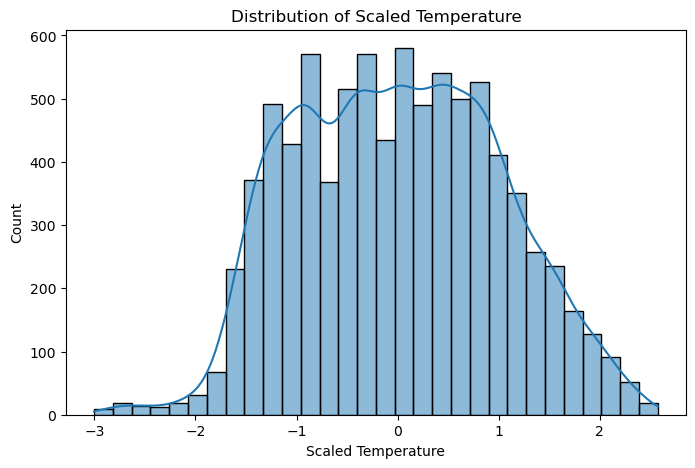

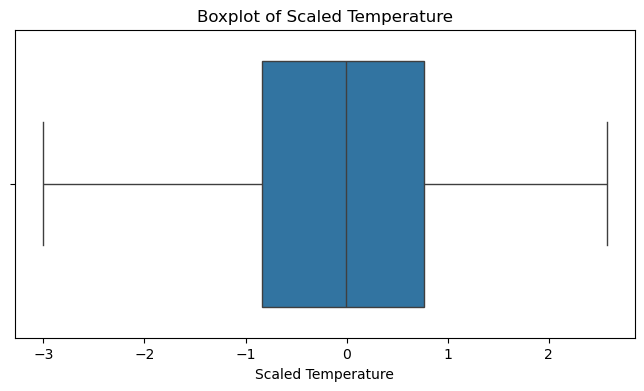

In [67]:
plot_numeric_distribution(X_train, "num__temp_C", label="Scaled Temperature")